# Ksn plotting 

Script to plot the graphs for ksn distortion.
Author: Marina Ruiz Sánchez-Oro

In [1]:
import numpy as np
import pandas as pd

import zarr
import matplotlib.pyplot as plt
import os
import helplotlib as hpl
import lsdtopytools as lsd
import cmcrameri.cm as cmc
import seaborn as sns
import re

import pickle
import itertools
from matplotlib.offsetbox import AnchoredText

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # Keep this or the code breaks because the HDF files aren't closed properly.


In [2]:
def format_string(string_to_format):
    formatted_string = string_to_format.replace("_", " ")
    formatted_string = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", formatted_string).strip()
    return formatted_string.capitalize()

In [3]:
base_path = '/exports/csce/datastore/geos/users/s1440040/LSDTopoTools/data/ExampleTopoDatasets/ChiAnalysisData/dems_to_process/'
file_name = 'ksn_ratios.csv'

ksn_dataframe = pd.read_csv(base_path+file_name)

In [4]:
mountain_names = list(ksn_dataframe.mountain)


In [5]:
mountain_names = list(map(format_string, mountain_names))

In [6]:
ksn_dataframe.mountain = mountain_names

In [18]:
min_values = []
max_values = []
for column in ksn_dataframe.columns[1:]:
    max_mountain = abs((1-ksn_dataframe.groupby(['mountain'], sort=False)[f'{column}'].max())).values
    min_mountain = abs((1-ksn_dataframe.groupby(['mountain'], sort=False)[f'{column}'].min())).values
    max_values.append(max_mountain)
    min_values.append(min_mountain)
    


In [15]:
min_max = np.maximum(max_values, min_values).round(2)

In [16]:
# calculate the average distortions
mean_min = np.array(min_values).mean(axis=1)
mean_max = np.array(max_values).mean(axis=1)
mean_min, mean_max

(array([0.33565771, 0.27293807, 0.13372571, 0.13876893]),
 array([0.34013914, 0.24120333, 0.26841307, 0.20243021]))

In [ ]:
hpl.mkfig_simple_bold(fontsize_major = 21, fontsize_minor= 14, family = "DejaVu Sans" , figsize = (10,8))


In [7]:
ksn_dataframe = ksn_dataframe.reindex(columns=['mountain','ksn_ratio_no_rain', 'ksn_ratio_rain', 'ksn_ratio_theta_45', 'ksn_ratio_theta_best'])

In [8]:
mountain_mapping = {'Peru': 'N. Andes', 'Argentina': 'S. Andes', 'Xian': 'Qinling', 
                    'Turkey': 'Kaçkar', 'Colorado': 'Rockies', 'Alburz south': 'Alburz', 'Massif central': 'Massif Central',
                    'Pyrenees': 'Pyrénées'}
ksn_dataframe['mountain'] = ksn_dataframe['mountain'].map(mountain_mapping)

ksn_ratio_no_rain
ksn_ratio_rain
ksn_ratio_theta_45
ksn_ratio_theta_best


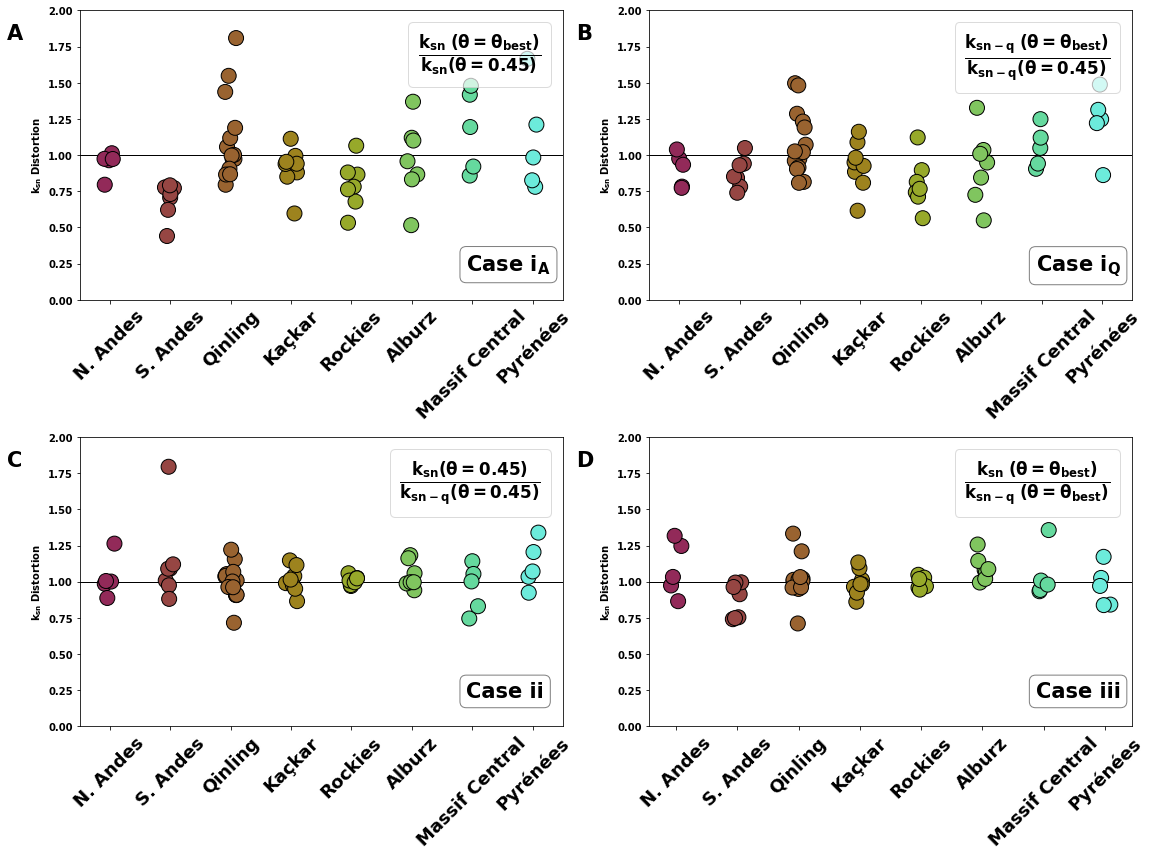

In [9]:
# plot all figures in one go
import matplotlib.patches as mpl_patches

plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = 24

base_path = '/exports/csce/datastore/geos/users/s1440040/LSDTopoTools/data/ExampleTopoDatasets/ChiAnalysisData/dems_to_process/'

y_labels = [
    r'$\frac{k_{{sn}}\;{{(\theta=\theta_{{best}})}}}{k_{{sn}}{{(\theta=0.45)}}}$',
    r'$\frac{k_{{sn-q}}\;{{(\theta=\theta_{{best}})}}}{k_{{sn-q}}{{(\theta=0.45)}}}$',
    r'$\frac{k_{{sn}}{{(\theta=0.45)}}}{k_{{sn-q}}{{(\theta=0.45)}}}$',
    r'$\frac{k_{{sn}}\;{{(\theta=\theta_{{best}})}}}{k_{{sn-q}}\;{{(\theta=\theta_{{best}})}}}$']
case_labels = [
    r'Case $i_{{A}}$',
    r'Case $i_{{Q}}$',
    r'Case ii',
    r'Case iii'
]

label_count = 0
column_names = ksn_dataframe.columns
ss_min = []
ss_max = []
legend_properties = {'weight':'bold', 'size':24}
fig, axs = plt.subplots(2,2, figsize=(16,12))
def plot_ksn_real(my_axs, label_count, col_name, subplot_letter):
    print(col_name)
    ss_min.append(round(abs(1-ksn_dataframe[col_name].min()), 2))
    ss_max.append(round(abs(1-ksn_dataframe[col_name].max()),2))
    graph = sns.stripplot(ax = my_axs,x=ksn_dataframe['mountain'],
                  y = ksn_dataframe[col_name] ,
                  data = ksn_dataframe,
                  edgecolor="black",
                  alpha=1,
                  s=15,
                  linewidth=1.0,
                  palette = 'cmc.hawaii')
    my_axs.set_ylim([0, 2])
    my_axs.set_xlabel('')
    my_axs.set_ylabel(r'$k_{sn}\; Distortion$')
    my_axs.legend([],[], frameon=False)
    my_axs.set_xticklabels(ksn_dataframe['mountain'].unique(), rotation=45, fontsize=18)
    
    #my_axs.set_xticklabels(rotation=70)

    plt.scatter([], [])

    # create a list with two empty handles (or more if needed)
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                     lw=0, alpha=0)] #* 2

    # create the corresponding number of labels (= the text you want to display)
    labels = []
    labels.append(y_labels[label_count])
    my_axs.legend(handles, labels, loc='upper right', fontsize='x-large', 
              fancybox=True, framealpha=0.7, 
              handlelength=0, handletextpad=0, prop=legend_properties)

    plt.ticklabel_format(axis='y',useOffset=False)
    graph.axhline(1.000, linewidth=1, color='black')
    my_axs.text(-0.15, 0.9, subplot_letter, transform=my_axs.transAxes, 
            size=21, weight='bold')
    
    my_axs.text(0.8, 0.1, case_labels[label_count], transform=my_axs.transAxes,size=21, color='black',bbox=dict(boxstyle="round",
                   ec='Black',
                   fc='White', alpha=0.5
                   ))
    #my_axs.set_xticklabels(labels, rotation=45, ha='right')

plot_ksn_real(axs[0][0], 0, column_names[1], 'A')
plot_ksn_real(axs[0][1], 1, column_names[2], 'B')
plot_ksn_real(axs[1][0], 2, column_names[3], 'C')
plot_ksn_real(axs[1][1], 3, column_names[4], 'D')
plt.tight_layout()
#plt.savefig(base_path + f'ksn_distortion_all_grad_real_topo' +'.pdf', dpi = 400)

In [10]:
min_max_values = [ss_min]+[ss_max]

In [11]:
df= pd.DataFrame(min_max_values, columns =ksn_dataframe.columns[1:])
min_or_max = ['min', 'max']
df['min_or_max'] = min_or_max 
#df.to_csv('min_max_ksn_real_landscapes.csv')